# 기본 준비

In [ ]:
!pip install --upgrade xgboost

In [ ]:
import xgboost
print(xgboost.__version__)

In [1]:
import pandas as pd
import numpy as np
import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import Binarizer
from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
pd.set_option("display.max_colwidth", None)
# pd.set_option("display.max_rows", None)

In [4]:
# 오차행렬 및 평가지표 출력
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = 0
    
    if pred_proba:
        roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)

    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


# 임계값 조정하여 오차행렬 및 평가지표 출력
def get_eval_by_threshold(y_test, pred, pred_proba_c1, thresholds):
    pred_proba_c1 = pred_proba_c1.reshape(-1, 1)
    for custom_threshold in thresholds:
        binar = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binar.transform(pred_proba_c1)
        print("분류 임계값:", custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
    

# 임계값별로 precison_recall_curve 그리기
def precision_recall_curve_plot(y_test, pred_proba_c1): 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]

    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision') 
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [21]:
def make_eval_df(model, m=0):
    if m == 0:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    pred = model.predict(X_test)
    confusion = str(confusion_matrix(y_test, pred)).replace("\n", "").replace("[ ", "[")
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    try:
        pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, pred_proba)
    except:
        roc_auc = 0
    
    return pd.DataFrame([{"model": str(model).replace("\n", ""), 
                          "params": str(model.get_params()),
                          "confusion": confusion,
                          "accuracy": accuracy,
                          "precision": precision,
                          "recall": recall,
                          "f1": f1,
                          "roc_auc": roc_auc}])

col_list = ["model", "params", "confusion", "accuracy", "precision", "recall", "f1", "roc_auc"]

## 데이터 준비

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data_path = "/content/drive/MyDrive/multicampus/data/"
#data_path = "../data/"

In [ ]:
data_path = "/content/drive/MyDrive/"

In [8]:
def prepare_data_smote():
    brfss = pd.read_csv(data_path + "brfss.csv")
    X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
    y = brfss["HEARTDISEASE"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(y_train.value_counts())
    print(y_test.value_counts())
    
    return X_train, X_test, y_train, y_test

In [ ]:
def prepare_data_adasyn():
    brfss = pd.read_csv(data_path + "../content/brfss.csv")
    X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
    y = brfss["HEARTDISEASE"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    adasyn = ADASYN()
    X_train, y_train = adasyn.fit_resample(X_train, y_train)

    print(y_train.value_counts())
    print(y_test.value_counts())

    return X_train, X_test, y_train, y_test

# 할 일
- 하이퍼 파라미터 튜닝
    - 각 모델 document 보면서 찾아보기
- 임계점 변경
    - 변경해보면서 최적값 찾기

## XGBClassifier

### 모델링
- 하이퍼 파라미터  
    - **eta(learning_rate)**
        - 0.0, 0.0001, 0.001, 0.1, 0.2, 0.25, 0.3
        - 오류나서 사용 X
    - **eval_metric**: 
        - "logloss", "rmse", "error"
    - **max_depth**
        - 3, 5, 6, 8, 10
    - **objective**
        - "binary:logitic", "multi:softmax"
        - 오류나서 사용 X
    - **min_chil_weight**
        - 0.01, 0.1, 1, 10, 100  
    - **colsample_bytree**
        - 0.5, 0.75, 1.0
    - **gamma**
        - [0.01, 0.1, 10]
        - 오류나서 사용 X

https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-categorical-feature

---

- 선택한 모델
    1. ```XGBClassifier(colsample_bytree=0.75, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], max_depth=5,\n min_child_weight=10, verbose=True)```
    2. ```XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.01,\n verbose=True)```
    3. ```XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.1,\n verbose=True)```
- 선택 기준
    - ```precision > .12```

In [ ]:
def prepare_data_smote():
    brfss = pd.read_csv(data_path + "brfss.csv")
    X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
    y = brfss["HEARTDISEASE"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(y_train.value_counts())
    print(y_test.value_counts())
    
    return X_train, X_test, y_train, y_test

참고
- https://velog.io/@sset2323/04-06.-XGBoosteXtra-Gradient-Boost
- http://aispiration.com/model/model-python-xgboost-hyper.html
- https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-categorical-feature

### 1차

In [ ]:
#eta = [0.001, 0.01, 0.1, 0.2, 0.3] 
#n_estimators = [10, 100, 1000] 
min_child_weight_list = [0.01, 0.1, 1, 10, 100]
gamma_list = [0, 0.01, 0.1, 10] 
max_depth_list = [3, 5, 6, 8, 10] 
#objective_list = ["binary:logitic", "multi:softmax"] 
eval_metric = ["rmse", "error", "logloss"]
colsample_bytree_list = [0.5, 0.75, 1] 

X_train, X_test, y_train, y_test = prepare_data_smote()
evals = [(X_test, y_test)]

xgb_df = pd.DataFrame(columns=["model", "confusion", "accuracy", "precision", "recall", "f1", "roc_auc"])

for max_depth in tqdm(max_depth_list, desc="max_depth"):
    for min_child_weight in tqdm(min_child_weight_list, desc="min_child_weight"):
        for colsample_bytree in tqdm(colsample_bytree_list, desc="colsample_bytree"):
            xgb_model = XGBClassifier(early_stopping_rounds=100, eval_set=eval_metric, verbose=True,
                                      #eta = eta,
                                      eval_metric=eval_metric,
                                      max_depth=max_depth,
                                      min_child_weight=min_child_weight,
                                      colsample_bytree=colsample_bytree)
            xgb_df = pd.concat([xgb_df, make_eval_df(xgb_model)], axis=0, ignore_index=True)

0.0    286806
1.0    286806
Name: HEARTDISEASE, dtype: int64
0.0    71618
1.0     4112
Name: HEARTDISEASE, dtype: int64


max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/5 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/5 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/5 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/5 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/5 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
xgb_df.sort_values("precision", ascending=False).head(10)

,model,confusion,accuracy,precision,recall,f1,roc_auc
25,"XGBClassifier(colsample_bytree=0.75, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], max_depth=5,\n min_child_weight=10, verbose=True)",[[54294 17324] [1672 2440]],0.749161,0.123457,0.593385,0.204389,0.744411
2,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.01,\n verbose=True)",[[53047 18571] [1507 2605]],0.734874,0.123017,0.633512,0.206027,0.755554
5,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.1,\n verbose=True)",[[53047 18571] [1507 2605]],0.734874,0.123017,0.633512,0.206027,0.755554
8,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], verbose=True)",[[53047 18571] [1507 2605]],0.734874,0.123017,0.633512,0.206027,0.755554
11,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=10,\n verbose=True)",[[53047 18571] [1507 2605]],0.734874,0.123017,0.633512,0.206027,0.755558
13,"XGBClassifier(colsample_bytree=0.75, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=100,\n verbose=True)",[[53113 18505] [1518 2594]],0.735600,0.122944,0.630837,0.205783,0.755341
17,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], max_depth=5,\n min_child_weight=0.01, verbose=True)",[[54195 17423] [1671 2441]],0.747867,0.122886,0.593628,0.203620,0.743973
20,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], max_depth=5,\n min_child_weight=0.1, verbose=True)",[[54195 17423] [1671 2441]],0.747867,0.122886,0.593628,0.203620,0.743973
23,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], max_depth=5, verbose=True)",[[54211 17407] [1675 2437]],0.748026,0.122808,0.592656,0.203456,0.743830
14,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=100,\n verbose=True)",[[53000 18618] [1507 2605]],0.734253,0.122744,0.633512,0.205644,0.755876


In [ ]:
xgb_df.head()

,model,confusion,accuracy,precision,recall,f1,roc_auc
0,"XGBClassifier(colsample_bytree=0.5, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.01,\n verbose=True)",[[52923 18695] [1515 2597]],0.733131,0.121971,0.631566,0.204456,0.756047
1,"XGBClassifier(colsample_bytree=0.75, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.01,\n verbose=True)",[[53015 18603] [1513 2599]],0.734372,0.122583,0.632053,0.205341,0.755410
2,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.01,\n verbose=True)",[[53047 18571] [1507 2605]],0.734874,0.123017,0.633512,0.206027,0.755554
3,"XGBClassifier(colsample_bytree=0.5, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.1,\n verbose=True)",[[52923 18695] [1515 2597]],0.733131,0.121971,0.631566,0.204456,0.756047
4,"XGBClassifier(colsample_bytree=0.75, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.1,\n verbose=True)",[[53015 18603] [1513 2599]],0.734372,0.122583,0.632053,0.205341,0.755410


In [ ]:
xgb_df.to_csv("./XGBOOST_smote_1.csv", index=False)

In [ ]:
xgb_df

,model,confusion,accuracy,precision,recall,f1,roc_auc
0,"XGBClassifier(colsample_bytree=0.5, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.01,\n verbose=True)",[[52923 18695] [1515 2597]],0.733131,0.121971,0.631566,0.204456,0.756047
1,"XGBClassifier(colsample_bytree=0.75, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.01,\n verbose=True)",[[53015 18603] [1513 2599]],0.734372,0.122583,0.632053,0.205341,0.755410
2,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.01,\n verbose=True)",[[53047 18571] [1507 2605]],0.734874,0.123017,0.633512,0.206027,0.755554
3,"XGBClassifier(colsample_bytree=0.5, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.1,\n verbose=True)",[[52923 18695] [1515 2597]],0.733131,0.121971,0.631566,0.204456,0.756047
4,"XGBClassifier(colsample_bytree=0.75, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], min_child_weight=0.1,\n verbose=True)",[[53015 18603] [1513 2599]],0.734372,0.122583,0.632053,0.205341,0.755410
...,...,...,...,...,...,...,...
70,"XGBClassifier(colsample_bytree=0.75, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], max_depth=10,\n min_child_weight=10, verbose=True)",[[55064 16554] [1835 2277]],0.757177,0.120918,0.553745,0.198492,0.724573
71,"XGBClassifier(early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], max_depth=10,\n min_child_weight=10, verbose=True)",[[55064 16554] [1864 2248]],0.756794,0.119562,0.546693,0.196212,0.719321
72,"XGBClassifier(colsample_bytree=0.5, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], max_depth=10,\n min_child_weight=100, verbose=True)",[[55087 16531] [1812 2300]],0.757784,0.122139,0.559339,0.200497,0.738582
73,"XGBClassifier(colsample_bytree=0.75, early_stopping_rounds=100,\n eval_metric=['rmse', 'error', 'logloss'],\n eval_set=['rmse', 'error', 'logloss'], max_depth=10,\n min_child_weight=100, verbose=True)",[[55257 16361] [1828 2284]],0.759818,0.122499,0.555447,0.200729,0.733545


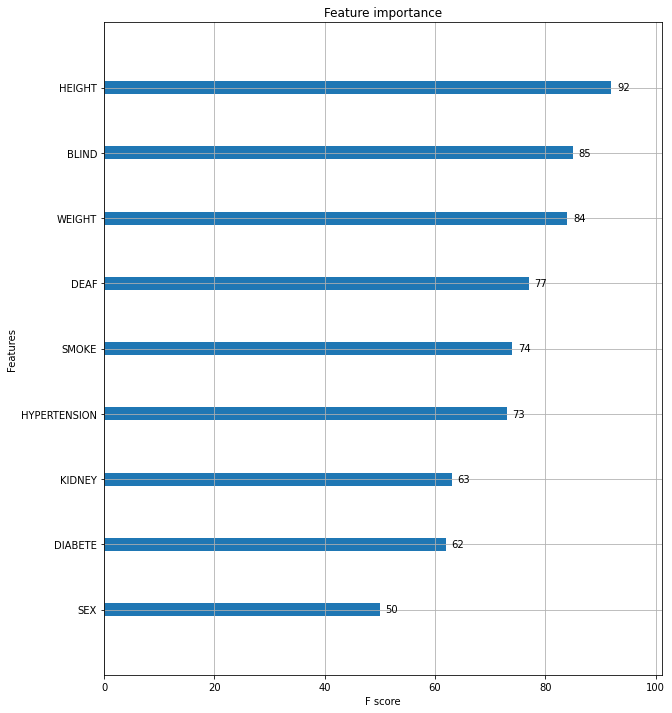

In [ ]:
model = xgb_df.sort_values("precision", ascending=False).loc[0, "model"]
fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(model, ax=ax)

### 2차
    - n_estimators 추가
    - min_child_weight 정수 추가
    - objective default로 설정

In [9]:
import xgboost
print(xgboost.__version__)

1.7.2


In [22]:
n_estimators_list = [50, 100, 500] 
min_child_weight_list = [1, 10, 100]
max_depth_list = [3, 5, 8, 10] 
colsample_bytree_list = [0.5, 0.75, 1] 
eval_metric_list = ["rmse", "error", "logloss"]

X_train, X_test, y_train, y_test = prepare_data_smote()
eval_set = [(X_test, y_test)]

xgb_df = pd.DataFrame(columns=col_list)

for max_depth in tqdm(max_depth_list, desc="max_depth"):
    for min_child_weight in tqdm(min_child_weight_list, desc="min_child_weight"):
        for colsample_bytree in tqdm(colsample_bytree_list, desc="colsample_bytree"):
            for n_estimators in tqdm(n_estimators_list, desc="n_estimators"):
                for eval_metric in tqdm(eval_metric_list, desc="eval_metric"):
                    xgb_model = XGBClassifier(early_stopping_rounds=100, # eval_set=eval_set, 
                                              eval_metric=eval_metric,
                                              n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_child_weight=min_child_weight,  
                                              colsample_bytree=colsample_bytree)
                    xgb_df = pd.concat([xgb_df, make_eval_df(xgb_model, m=1)], axis=0, ignore_index=True)

0.0    286691
1.0    286691
Name: HEARTDISEASE, dtype: int64
0.0    71733
1.0     3997
Name: HEARTDISEASE, dtype: int64


max_depth:   0%|          | 0/4 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
xgb_df.to_csv(save_path + "XGBoost_2.csv", index=False)

In [42]:
n_estimators_list = [50, 100] 
min_child_weight_list = [1, 10]
max_depth_list = [4, 5, 6] 
colsample_bytree_list = [0.75, 1] 
eval_metric_list = ["rmse", "error", "logloss"]

X_train, X_test, y_train, y_test = prepare_data_smote()
eval_set = [(X_test, y_test)]

xgb_df = pd.DataFrame(columns=col_list)

for max_depth in tqdm(max_depth_list, desc="max_depth"):
    for min_child_weight in tqdm(min_child_weight_list, desc="min_child_weight"):
        for colsample_bytree in tqdm(colsample_bytree_list, desc="colsample_bytree"):
            for n_estimators in tqdm(n_estimators_list, desc="n_estimators"):
                for eval_metric in tqdm(eval_metric_list, desc="eval_metric"):
                    xgb_model = XGBClassifier(early_stopping_rounds=100,
                                              eval_metric=eval_metric,
                                              n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_child_weight=min_child_weight,  
                                              colsample_bytree=colsample_bytree)
                    xgb_df = pd.concat([xgb_df, make_eval_df(xgb_model, m=1)], axis=0, ignore_index=True)

0.0    286801
1.0    286801
Name: HEARTDISEASE, dtype: int64
0.0    71623
1.0     4107
Name: HEARTDISEASE, dtype: int64


max_depth:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/2 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/2 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/2 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/2 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/2 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/2 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

min_child_weight:   0%|          | 0/2 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/2 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

colsample_bytree:   0%|          | 0/2 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

eval_metric:   0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
xgb_df.to_csv(save_path + "XGBoost_3.csv", index=False)

In [45]:
xgb_result = pd.read_csv(save_path + "XGBoost_3.csv")
xgb_result = xgb_result.sort_values("precision", ascending=False)
xgb_result["precision"].unique()

array([0.12353226, 0.12160104, 0.12151361, 0.12118135, 0.12115181,
       0.12111985, 0.12109028, 0.11152778, 0.11147955, 0.11147174,
       0.11146578, 0.11142352, 0.11101228, 0.1109885 , 0.11097661,
       0.11096508, 0.1109648 , 0.11095691, 0.11090954, 0.11082337,
       0.11079979, 0.11079193, 0.11079172, 0.11078386])

In [50]:
xgb_temp = xgb_result[xgb_result["precision"]>.123]

In [51]:
xgb_temp.to_csv(save_path + "XGBoost_final.csv", index=False)

In [52]:
xgb_temp

,model,params,confusion,accuracy,precision,recall,f1,roc_auc
31,"XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=100, enable_categorical=False, eval_metric='error', feature_types=None, gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)","{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': 100, 'enable_categorical': False, 'eval_metric': 'error', 'feature_types': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 5, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}",[[51693 19930] [1298 2809]],0.719688,0.123532,0.683954,0.209268,0.768019
34,"XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=100, enable_categorical=False, eval_metric='error', feature_types=None, gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)","{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': 100, 'enable_categorical': False, 'eval_metric': 'error', 'feature_types': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 5, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}",[[51693 19930] [1298 2809]],0.719688,0.123532,0.683954,0.209268,0.768019
46,"XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=100, enable_categorical=False, eval_metric='error', feature_types=None, gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=10, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)","{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': 100, '